## Load packages 

In [1]:
import pandas as pd
import altair as alt
from vega_datasets import data
import pandas_profiling
import seaborn as sns
import numpy as np

# Need to enable this to allow work with larger datasets (https://altair-viz.github.io/user_guide/faq.html)
alt.data_transformers.enable('json')

# Need to enable this to render in notebook
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

## Loading datasets

In [30]:
# World Bank data
map_and_bar_df = pd.read_csv('../data/clean_map_and_bar_data.csv', index_col=0)
compare_chart_df = pd.read_csv('../data/clean_comparison_chart_data.csv', index_col=0)

## Plotting

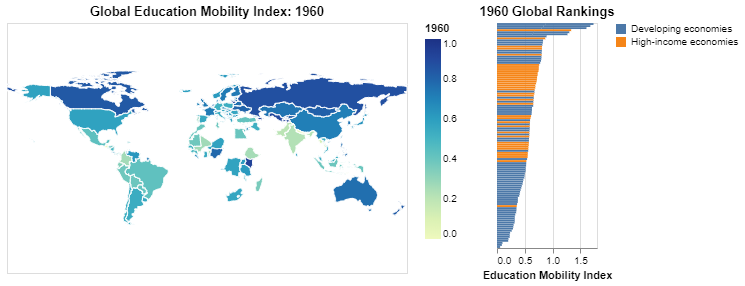

In [19]:
def map_and_bar_by_year(year, map_and_bar_df):
    """
    ADD DOCUMENTATION HERE
    """
    # json base country map data 
    country_map = alt.topo_feature(data.world_110m.url, 'countries')
    
    quote_yr = str(year)
    selection = alt.selection_multi(fields = ['countryname'], resolve='global')
    map_chart = alt.Chart(country_map).mark_geoshape(
        stroke='white',
        fill='lightgray'
    ).encode(
        color=alt.condition(selection,
                           alt.Color(quote_yr, type='quantitative',
                                    scale=alt.Scale(domain=[0, 1])),
                           alt.value('lightgray'),
                           legend=alt.Legend(title="EMI")),
        tooltip = [
            alt.Tooltip('countryname:N', title="country"),
            alt.Tooltip(f'{year}:Q', title="EMI")
        ]
    ).transform_lookup(
        lookup='id',
        from_=alt.LookupData(map_and_bar_df,'country_num', [quote_yr, 'countryname'])
    ).properties(
        width=600
    ).project(
        'equirectangular'
    ).properties(title=f'Global Education Mobility Index: {year}',
                height=250,
                width=400).add_selection(selection)#.interactive()
    
    plot_dict = {
        '1940': map_and_bar_df.dropna(subset=['1940']),
        '1950': map_and_bar_df.dropna(subset=['1950']),
        '1960': map_and_bar_df.dropna(subset=['1960']),
        '1970': map_and_bar_df.dropna(subset=['1970']),
        '1980': map_and_bar_df.dropna(subset=['1980'])
    }
    
    bar_chart_data = plot_dict[quote_yr]
    
    bar_chart = alt.Chart(bar_chart_data.loc[bar_chart_data['child'] == 'all']).mark_bar().encode(
        alt.X(f'{quote_yr}:Q', title="Education Mobility Index"),
        alt.Y('countryname', axis=None, title='',
        sort=alt.EncodingSortField(field=quote_yr,
                                   order="descending")),
        #color=alt.Color('incgroup2'),
        color=alt.condition(selection,
                            'incgroup2',
                            alt.value('lightgray'),
                            legend=alt.Legend(title="")
        ),
        tooltip = [
            alt.Tooltip('countryname:N', title="country"),
            alt.Tooltip(f'{quote_yr}:Q', title="EMI")
        ]
    ).properties(title=f'{year} Global Rankings', height = 225, width = 100).add_selection(selection)
      
    
    map_and_bar = (map_chart | bar_chart)
    
    return map_and_bar 


map_and_bar_by_year(1960, map_and_bar_df)

In [88]:
def line_charts(compare_chart_df, country_list):
    """
    ADD DOCUMENTATION HERE
    """
    # Create a selection that chooses the nearest point & selects based on x-value
    nearest = alt.selection(type='single', nearest=True, on='mouseover',
                        fields=['year'], empty='none')
    
    
    data_to_plot = compare_chart_df[compare_chart_df.countryname.isin(country_list)]
    
    line_chart = alt.Chart(data_to_plot).mark_line(clip=True).encode(
        alt.X('year:N', axis=alt.Axis(labelAngle=0), title="Generation"),
        alt.Y('EMI:Q', scale=alt.Scale(domain=(0,1))),
        alt.Color('countryname:N', title="")
    )
    
    # Transparent selectors across the chart. This is what tells us
    # the x-value of the cursor
    selectors = alt.Chart(data_to_plot).mark_point().encode(
        x='year:N',
        opacity=alt.value(0),
    ).add_selection(
        nearest
    )

    # Draw points on the line, and highlight based on selection
    points = line_chart.mark_point().encode(
        opacity=alt.condition(nearest, alt.value(1), alt.value(0))
    )

    # Draw text labels near the points, and highlight based on selection
    text = line_chart.mark_text(align='left', dx=5, dy=-5).encode(
        text=alt.condition(nearest, 'EMI:Q', alt.value(' '))
    ).transform_calculate(label=f'format(datum.EMI,".3f")')
    
    rules = alt.Chart(data_to_plot).mark_rule(color='gray').encode(
        x='year:N',
    ).transform_filter(
        nearest
    )
    
    interactive_line_chart = alt.layer(
        line_chart, selectors, points, rules, text
    ).properties(
        width=250, height=150
    ).facet(
        column='child:N'
    ).interactive()
    
    return interactive_line_chart

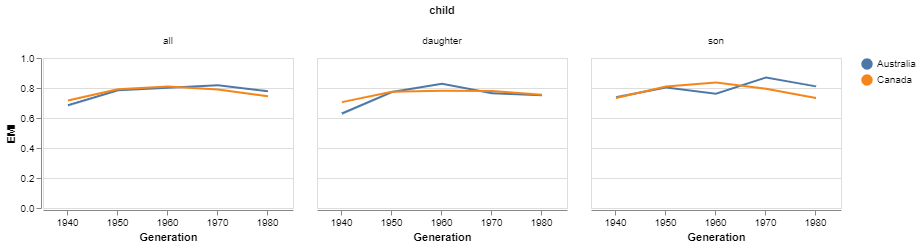

In [89]:
line_charts(compare_chart_df, ['Australia', 'Canada'])

In [ ]:
def basic_line_charts(compare_chart_df, country_list):
    """
    ADD DOCUMENTATION HERE
    """
    
    data_to_plot = compare_chart_df[compare_chart_df.countryname.isin(country_list)]
    
    line_chart = alt.Chart(data_to_plot).mark_line(clip=True).encode(
        alt.X('year:N', axis=alt.Axis(labelAngle=0), title="Generation"),
        alt.Y('EMI:Q', scale=alt.Scale(domain=(0,1))),
        alt.Color('countryname:N', title="")
    ).properties(
        width = 150, 
        height = 150, 
        title = "",
    ).facet(
        column='child:N'
    )
    
    
    return line_chart